This script process the raw count from cell ranger to generate umap

- Initial Date: 12/8/2025

In [1]:
# Set 'Liberation Sans' as the default font
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'

1. LOADING AND SUBSETTING DATA
Loaded adata: 17357 cells x 32285 genes

Sample distribution in 'sample':
sample
D3_1    9728
D0_1    7629
Name: count, dtype: int64

2. QUALITY CONTROL

QC metrics added to adata.obs:
['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb']
QC plots saved.

3. BASIC FILTERING
filtered out 8164 genes that are detected in less than 3 cells
Cells: 17357 -> 17357 (0 removed)
Genes: 32285 -> 24121 (8164 removed)


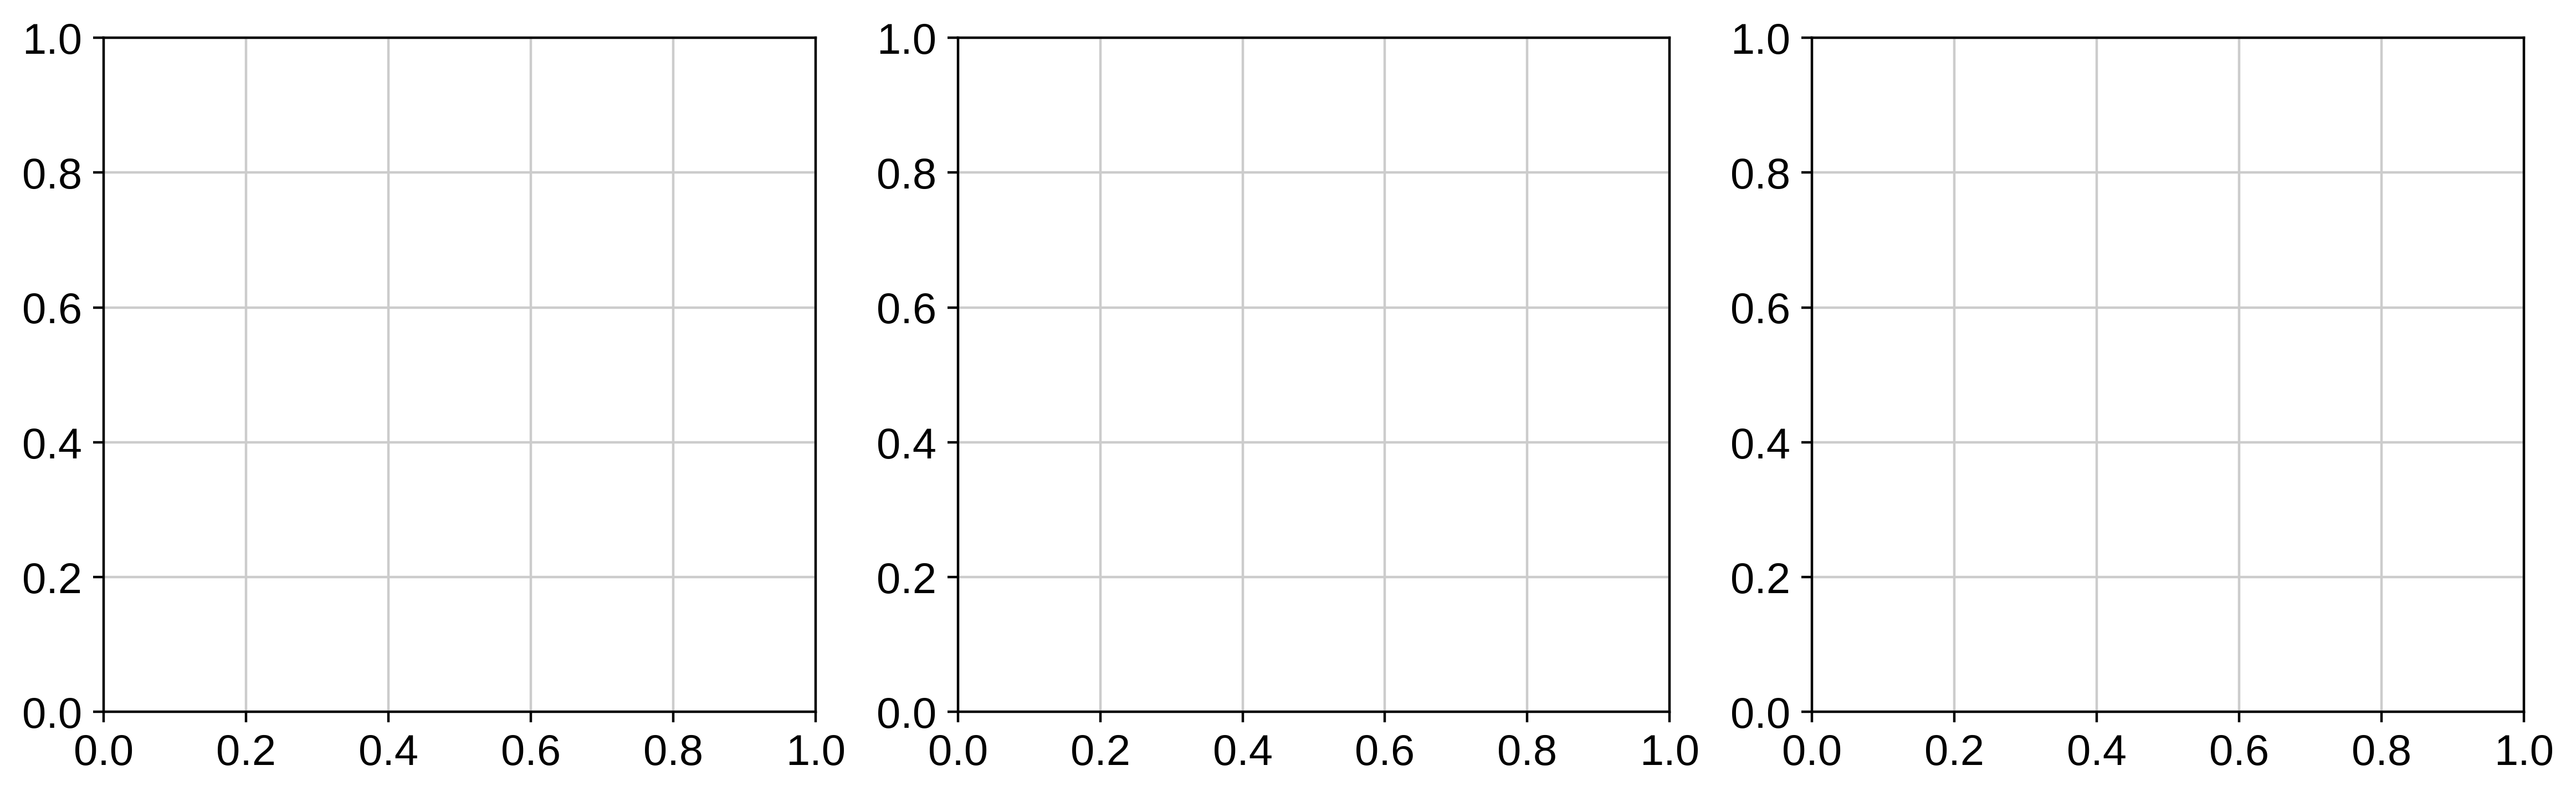

In [2]:
#!/usr/bin/env python
"""
Standard Scanpy Analysis Pipeline for D0_1 and D3_1 samples
Following: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

No integration step - just standard preprocessing, QC, normalization, 
dimensionality reduction, and clustering.
"""

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

# Set scanpy settings
sc.settings.set_figure_params(dpi=200, facecolor='white', figsize=(6, 5))
sc.settings.verbosity = 3

# =============================================================================
# CONFIGURATION - Update these paths
# =============================================================================
# Input: Combined h5ad file with D0_1 and D3_1 samples
INPUT_H5AD = "/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/raw_count_cellranger.h5ad"

# Output directory
OUTPUT_DIR = "/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/analysis/raw_count/standard_analysis/no_integration/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sample column name
SAMPLE_COL = "sample"  # or "sample" depending on your data

# Samples to subset
SAMPLES_TO_USE = ["D0_1", "D3_1"]

# =============================================================================
# 1. LOAD DATA AND SUBSET TO D0_1 AND D3_1
# =============================================================================
print("=" * 60)
print("1. LOADING AND SUBSETTING DATA")
print("=" * 60)

# Load the combined adata
adata = sc.read_h5ad(INPUT_H5AD)
print(f"Loaded adata: {adata.shape[0]} cells x {adata.shape[1]} genes")

# Check sample column
print(f"\nSample distribution in '{SAMPLE_COL}':")
print(adata.obs[SAMPLE_COL].value_counts())

# # Subset to D0_1 and D3_1 only
# adata = adata[adata.obs[SAMPLE_COL].isin(SAMPLES_TO_USE)].copy()
# print(f"\nSubset to {SAMPLES_TO_USE}: {adata.shape[0]} cells x {adata.shape[1]} genes")
# print(adata.obs[SAMPLE_COL].value_counts())

# =============================================================================
# 2. QUALITY CONTROL
# =============================================================================
print("\n" + "=" * 60)
print("2. QUALITY CONTROL")
print("=" * 60)

# Mark gene types - for mouse, use "mt-" (lowercase) for mitochondrial
# Adjust prefixes based on your gene naming convention
adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-"))  # mitochondrial
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl", "RPS", "RPL"))  # ribosomal
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]|^HB[^(P)]", regex=True)  # hemoglobin

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mt", "ribo", "hb"], 
    inplace=True, 
    log1p=True
)

print("\nQC metrics added to adata.obs:")
print([c for c in adata.obs.columns if 'counts' in c or 'genes' in c or 'pct' in c])

# Plot QC metrics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Violin plots
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    ax=axes,
    show=False
)
plt.savefig(OUTPUT_DIR + "01_qc_violin.png", dpi=300, bbox_inches='tight')
plt.close()

# Scatter plot: counts vs genes, colored by mito %
sc.pl.scatter(
    adata, 
    x="total_counts", 
    y="n_genes_by_counts", 
    color="pct_counts_mt",
    show=False
)
plt.savefig(OUTPUT_DIR + "02_qc_scatter.png", dpi=300, bbox_inches='tight')
plt.close()

# QC by sample
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, metric in enumerate(["n_genes_by_counts", "total_counts", "pct_counts_mt"]):
    sc.pl.violin(adata, metric, groupby=SAMPLE_COL, ax=axes[i], show=False)
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "03_qc_by_sample.png", dpi=300, bbox_inches='tight')
plt.close()

print("QC plots saved.")

# =============================================================================
# 3. BASIC FILTERING
# =============================================================================
print("\n" + "=" * 60)
print("3. BASIC FILTERING")
print("=" * 60)

n_cells_before = adata.n_obs
n_genes_before = adata.n_vars

# Basic filtering - adjust thresholds as needed
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(f"Cells: {n_cells_before} -> {adata.n_obs} ({n_cells_before - adata.n_obs} removed)")
print(f"Genes: {n_genes_before} -> {adata.n_vars} ({n_genes_before - adata.n_vars} removed)")

# Optional: Filter by mitochondrial content and total counts
# Uncomment and adjust thresholds based on your QC plots
# adata = adata[adata.obs['pct_counts_mt'] < 20, :]
# adata = adata[adata.obs['n_genes_by_counts'] < 6000, :]
# adata = adata[adata.obs['n_genes_by_counts'] > 500, :]



In [3]:
print(adata.obs[SAMPLE_COL].dtype)
print(adata.obs[SAMPLE_COL].unique())
print(adata.obs[SAMPLE_COL].isna().sum())  # Check for NaN values

category
['D0_1', 'D3_1']
Categories (2, object): ['D0_1', 'D3_1']
0


In [4]:
# =============================================================================
# 4. DOUBLET DETECTION
# =============================================================================
print("\n" + "=" * 60)
print("4. DOUBLET DETECTION")
print("=" * 60)

# Run Scrublet for doublet detection per sample
sc.pp.scrublet(adata, batch_key=SAMPLE_COL)

print(f"\nDoublet detection results:")
print(f"Predicted doublets: {adata.obs['predicted_doublet'].sum()} / {adata.n_obs}")
print(f"Mean doublet score: {adata.obs['doublet_score'].mean():.4f}")

# Doublet scores by sample
print("\nDoublets per sample:")
print(adata.obs.groupby(SAMPLE_COL)['predicted_doublet'].sum())

# =============================================================================
# 5. NORMALIZATION
# =============================================================================
print("\n" + "=" * 60)
print("5. NORMALIZATION")
print("=" * 60)

# Save raw counts to a layer
adata.layers["counts"] = adata.X.copy()

# Normalize to median total counts (log1PF normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print("Normalization complete (normalize_total + log1p)")
print(f"Data stored in adata.X, raw counts in adata.layers['counts']")

# =============================================================================
# 6. FEATURE SELECTION (HVG)
# =============================================================================
print("\n" + "=" * 60)
print("6. FEATURE SELECTION (HIGHLY VARIABLE GENES)")
print("=" * 60)

# Identify highly variable genes
# Using batch_key to account for sample-specific variation
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    batch_key=SAMPLE_COL,
    flavor='seurat_v3',
    layer='counts'  # Use raw counts for HVG selection
)

print(f"\nHighly variable genes: {adata.var['highly_variable'].sum()}")

# Plot HVG
sc.pl.highly_variable_genes(adata, show=False)
plt.savefig(OUTPUT_DIR + "04_hvg.png", dpi=300, bbox_inches='tight')
plt.close()

# =============================================================================
# 7. DIMENSIONALITY REDUCTION (PCA)
# =============================================================================
print("\n" + "=" * 60)
print("7. DIMENSIONALITY REDUCTION (PCA)")
print("=" * 60)

# Scale data (optional but recommended before PCA)
# Note: Only affects PCA, doesn't modify adata.X permanently if you use mask_var
# sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print(f"PCA complete: {adata.obsm['X_pca'].shape}")

# Plot variance ratio
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, show=False)
plt.savefig(OUTPUT_DIR + "05_pca_variance.png", dpi=300, bbox_inches='tight')
plt.close()

# PCA colored by sample and QC metrics
sc.pl.pca(
    adata,
    color=[SAMPLE_COL, "pct_counts_mt", "n_genes_by_counts", "doublet_score"],
    ncols=2,
    show=False
)
plt.savefig(OUTPUT_DIR + "06_pca_qc.png", dpi=300, bbox_inches='tight')
plt.close()




4. DOUBLET DETECTION
Running Scrublet
filtered out 3260 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 24.1%
Estimated detectable doublet fraction = 85.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 28.3%
filtered out 723 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'mean

In [5]:
# =============================================================================
# 8. NEIGHBOR GRAPH AND UMAP
# =============================================================================
print("\n" + "=" * 60)
print("8. NEIGHBOR GRAPH AND UMAP")
print("=" * 60)

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Compute UMAP
sc.tl.umap(adata)

print("UMAP complete.")

# Plot UMAP by sample
sc.pl.umap(adata, color=SAMPLE_COL, size=10, show=False)
plt.savefig(OUTPUT_DIR + "07_umap_sample.png", dpi=300, bbox_inches='tight')
plt.close()

# =============================================================================
# 9. CLUSTERING (LEIDEN)
# =============================================================================
print("\n" + "=" * 60)
print("9. CLUSTERING (LEIDEN)")
print("=" * 60)

# Run Leiden clustering at multiple resolutions
resolutions = [0.1, 0.3, 0.5, 0.8, 1.0]

for res in resolutions:
    sc.tl.leiden(
        adata, 
        key_added=f"leiden_res_{res:.1f}", 
        resolution=res,
        flavor="igraph",
        n_iterations=2
    )
    n_clusters = adata.obs[f"leiden_res_{res:.1f}"].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

# Plot all clustering resolutions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot sample
sc.pl.umap(adata, color=SAMPLE_COL, ax=axes[0], show=False, title="Sample")

# Plot each resolution
for i, res in enumerate(resolutions):
    sc.pl.umap(
        adata, 
        color=f"leiden_res_{res:.1f}", 
        ax=axes[i+1], 
        show=False,
        title=f"Leiden res={res}",
        legend_loc='on data' if res <= 0.5 else 'right margin'
    )

plt.tight_layout()
plt.savefig(OUTPUT_DIR + "08_leiden_resolutions.png", dpi=300, bbox_inches='tight')
plt.close()

# Set default clustering (choose based on your data)
adata.obs['leiden'] = adata.obs['leiden_res_0.5']

# =============================================================================
# 10. QC REASSESSMENT POST-CLUSTERING
# =============================================================================
print("\n" + "=" * 60)
print("10. QC REASSESSMENT POST-CLUSTERING")
print("=" * 60)

# UMAP with QC metrics and clustering
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score", "pct_counts_mt"],
    ncols=2,
    wspace=0.4,
    show=False
)
plt.savefig(OUTPUT_DIR + "09_umap_qc_assessment.png", dpi=300, bbox_inches='tight')
plt.close()

sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "log1p_n_genes_by_counts"],
    ncols=2,
    wspace=0.4,
    show=False
)
plt.savefig(OUTPUT_DIR + "10_umap_counts.png", dpi=300, bbox_inches='tight')
plt.close()

# Check cluster composition by sample
cluster_sample = pd.crosstab(
    adata.obs['leiden'], 
    adata.obs[SAMPLE_COL], 
    normalize='index'
) * 100
print("\nCluster composition by sample (%):")
print(cluster_sample.round(1))




8. NEIGHBOR GRAPH AND UMAP
computing neighbors
    using 'X_pca' with n_pcs = 30


2025-12-08 14:57:44.933405: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 14:57:44.981624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 14:57:46.698776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:11)
UMAP complete.

9. CLUSTERING (LEIDEN)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.1', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.1: 9 clusters
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res_0.3', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.3: 14 clusters
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_res_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.5: 18 clusters
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_res_0.8', the cluster labels (adata.obs, categorical) (0:00:00)
R

In [6]:
# =============================================================================
# 11. MARKER GENE DETECTION
# =============================================================================
print("\n" + "=" * 60)
print("11. MARKER GENE DETECTION")
print("=" * 60)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

# Plot top markers
sc.pl.rank_genes_groups_dotplot(
    adata, 
    groupby='leiden', 
    n_genes=5,
    standard_scale='var',
    show=False
)
plt.savefig(OUTPUT_DIR + "11_marker_dotplot.png", dpi=300, bbox_inches='tight')
plt.close()

# Save marker genes to CSV
markers_df = sc.get.rank_genes_groups_df(adata, group=None)
markers_df.to_csv(OUTPUT_DIR + "marker_genes_all_clusters.csv", index=False)
print(f"\nMarker genes saved to: {OUTPUT_DIR}marker_genes_all_clusters.csv")

# Top 5 markers per cluster
print("\nTop 5 markers per cluster:")
for cluster in adata.obs['leiden'].cat.categories:
    top5 = sc.get.rank_genes_groups_df(adata, group=cluster).head(5)['names'].tolist()
    print(f"  Cluster {cluster}: {', '.join(top5)}")

# =============================================================================
# 12. SAVE RESULTS
# =============================================================================
print("\n" + "=" * 60)
print("12. SAVING RESULTS")
print("=" * 60)

# Save the processed adata
output_path = OUTPUT_DIR + "adata_processed.h5ad"
# adata.write(output_path)
print(f"\nProcessed adata saved to: {output_path}")

# Summary
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"Final shape: {adata.n_obs} cells x {adata.n_vars} genes")
print(f"Samples: {adata.obs[SAMPLE_COL].unique().tolist()}")
print(f"Clusters (leiden res=0.5): {adata.obs['leiden'].nunique()}")
print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("""
Files generated:
  - 01_qc_violin.png
  - 02_qc_scatter.png
  - 03_qc_by_sample.png
  - 04_hvg.png
  - 05_pca_variance.png
  - 06_pca_qc.png
  - 07_umap_sample.png
  - 08_leiden_resolutions.png
  - 09_umap_qc_assessment.png
  - 10_umap_counts.png
  - 11_marker_dotplot.png
  - marker_genes_all_clusters.csv
  - adata_D0_D3_processed.h5ad
""")


11. MARKER GENE DETECTION
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:33)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`

Marker genes saved to: /home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/analysis/raw_count/standard_analysis/no_integration/marker_genes_all_clusters.csv

Top 5 markers per cluster:
  Cluster 0: Slc5a12, Slc34a1, Gatm, Fut9, Slc4a4
  Cluster 1: Meis2, Emcn, Flt1, Plpp1, Ldb2
  Cluster 2: Zbtb20, Slc22a30, Cyp4b1, Acsm2, Gm42397
  Cluster 3: Rbms3, Tshz2, Bicc1, Myo9a, Utrn
  Cluster 4: Tmem117, Bmpr1b, Itpr2, Pde1a, Tfcp2l1
  Cluster 5: Dach1, Mecom, Tsc22d1, Phactr1, Cadps2
  Cl

In [7]:
print(f"adata.layers['counts'] max: {adata.layers['counts'].max()}")
print(f"adata.X max: {adata.X.max()}")

adata.layers['counts'] max: 4429.0
adata.X max: 7.8940277099609375


In [8]:
adata

AnnData object with n_obs × n_vars = 17357 × 24121
    obs: 'sample', 'in_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'pANN_0.25_0.26_600', 'DF.classifications_0.25_0.26_600', 'doubletdata', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pANN_0.25_0.08_899', 'DF.classifications_0.25_0.08_899', 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA_clean', 'nFeature_RNA_clean', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT.weight', 'wsnn_res.0.6', 'wsnn_res.0.4', 'nCount_TSSaccessibility', 'nFeature_TSSaccessibility', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_coun

### load tacco label

In [16]:
# Load the labels
labels_df = pd.read_csv('/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/analysis/raw_count/label_transfer/tacco/tacco_labels.csv', index_col=0)

# Add to your existing adata (cell barcodes must match)
# Use .loc to align by index - only adds labels for matching barcodes
adata.obs['tacco_celltype'] = labels_df.loc[adata.obs_names, 'tacco_celltype']
adata.obs['tacco_confidence'] = labels_df.loc[adata.obs_names, 'tacco_confidence']

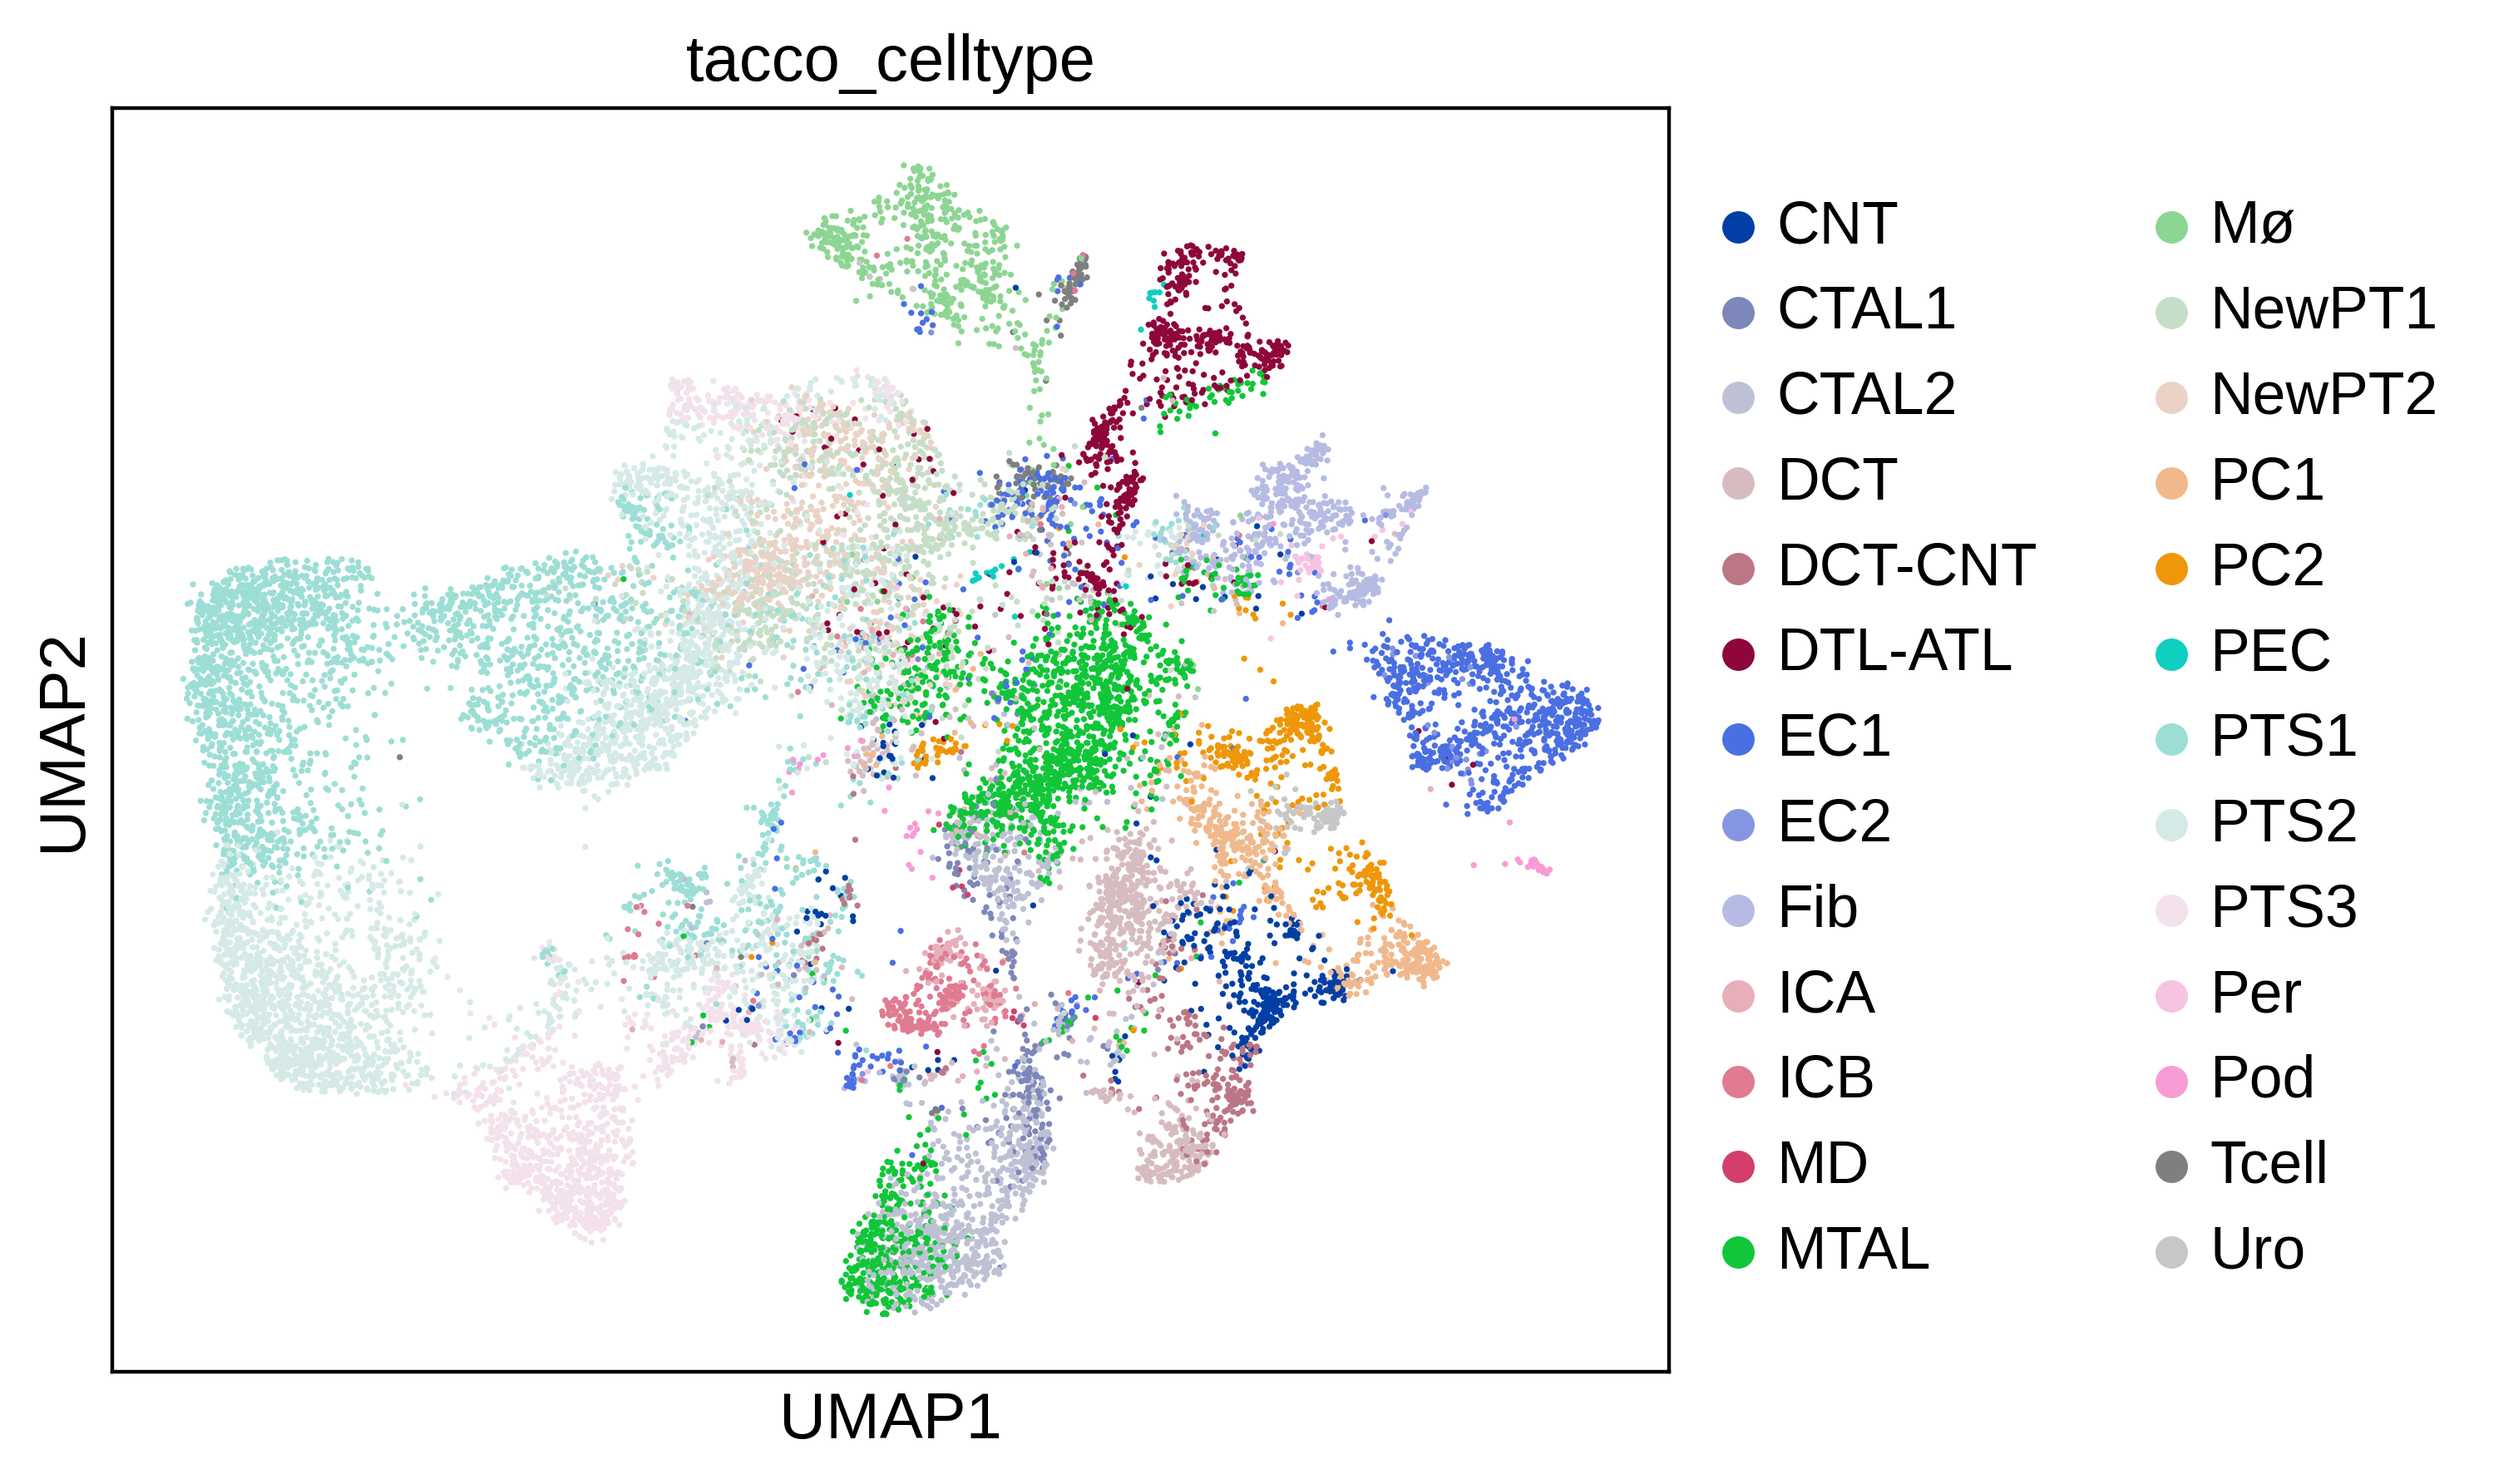

In [17]:
# Now visualize
sc.pl.umap(adata, color=['tacco_celltype'])

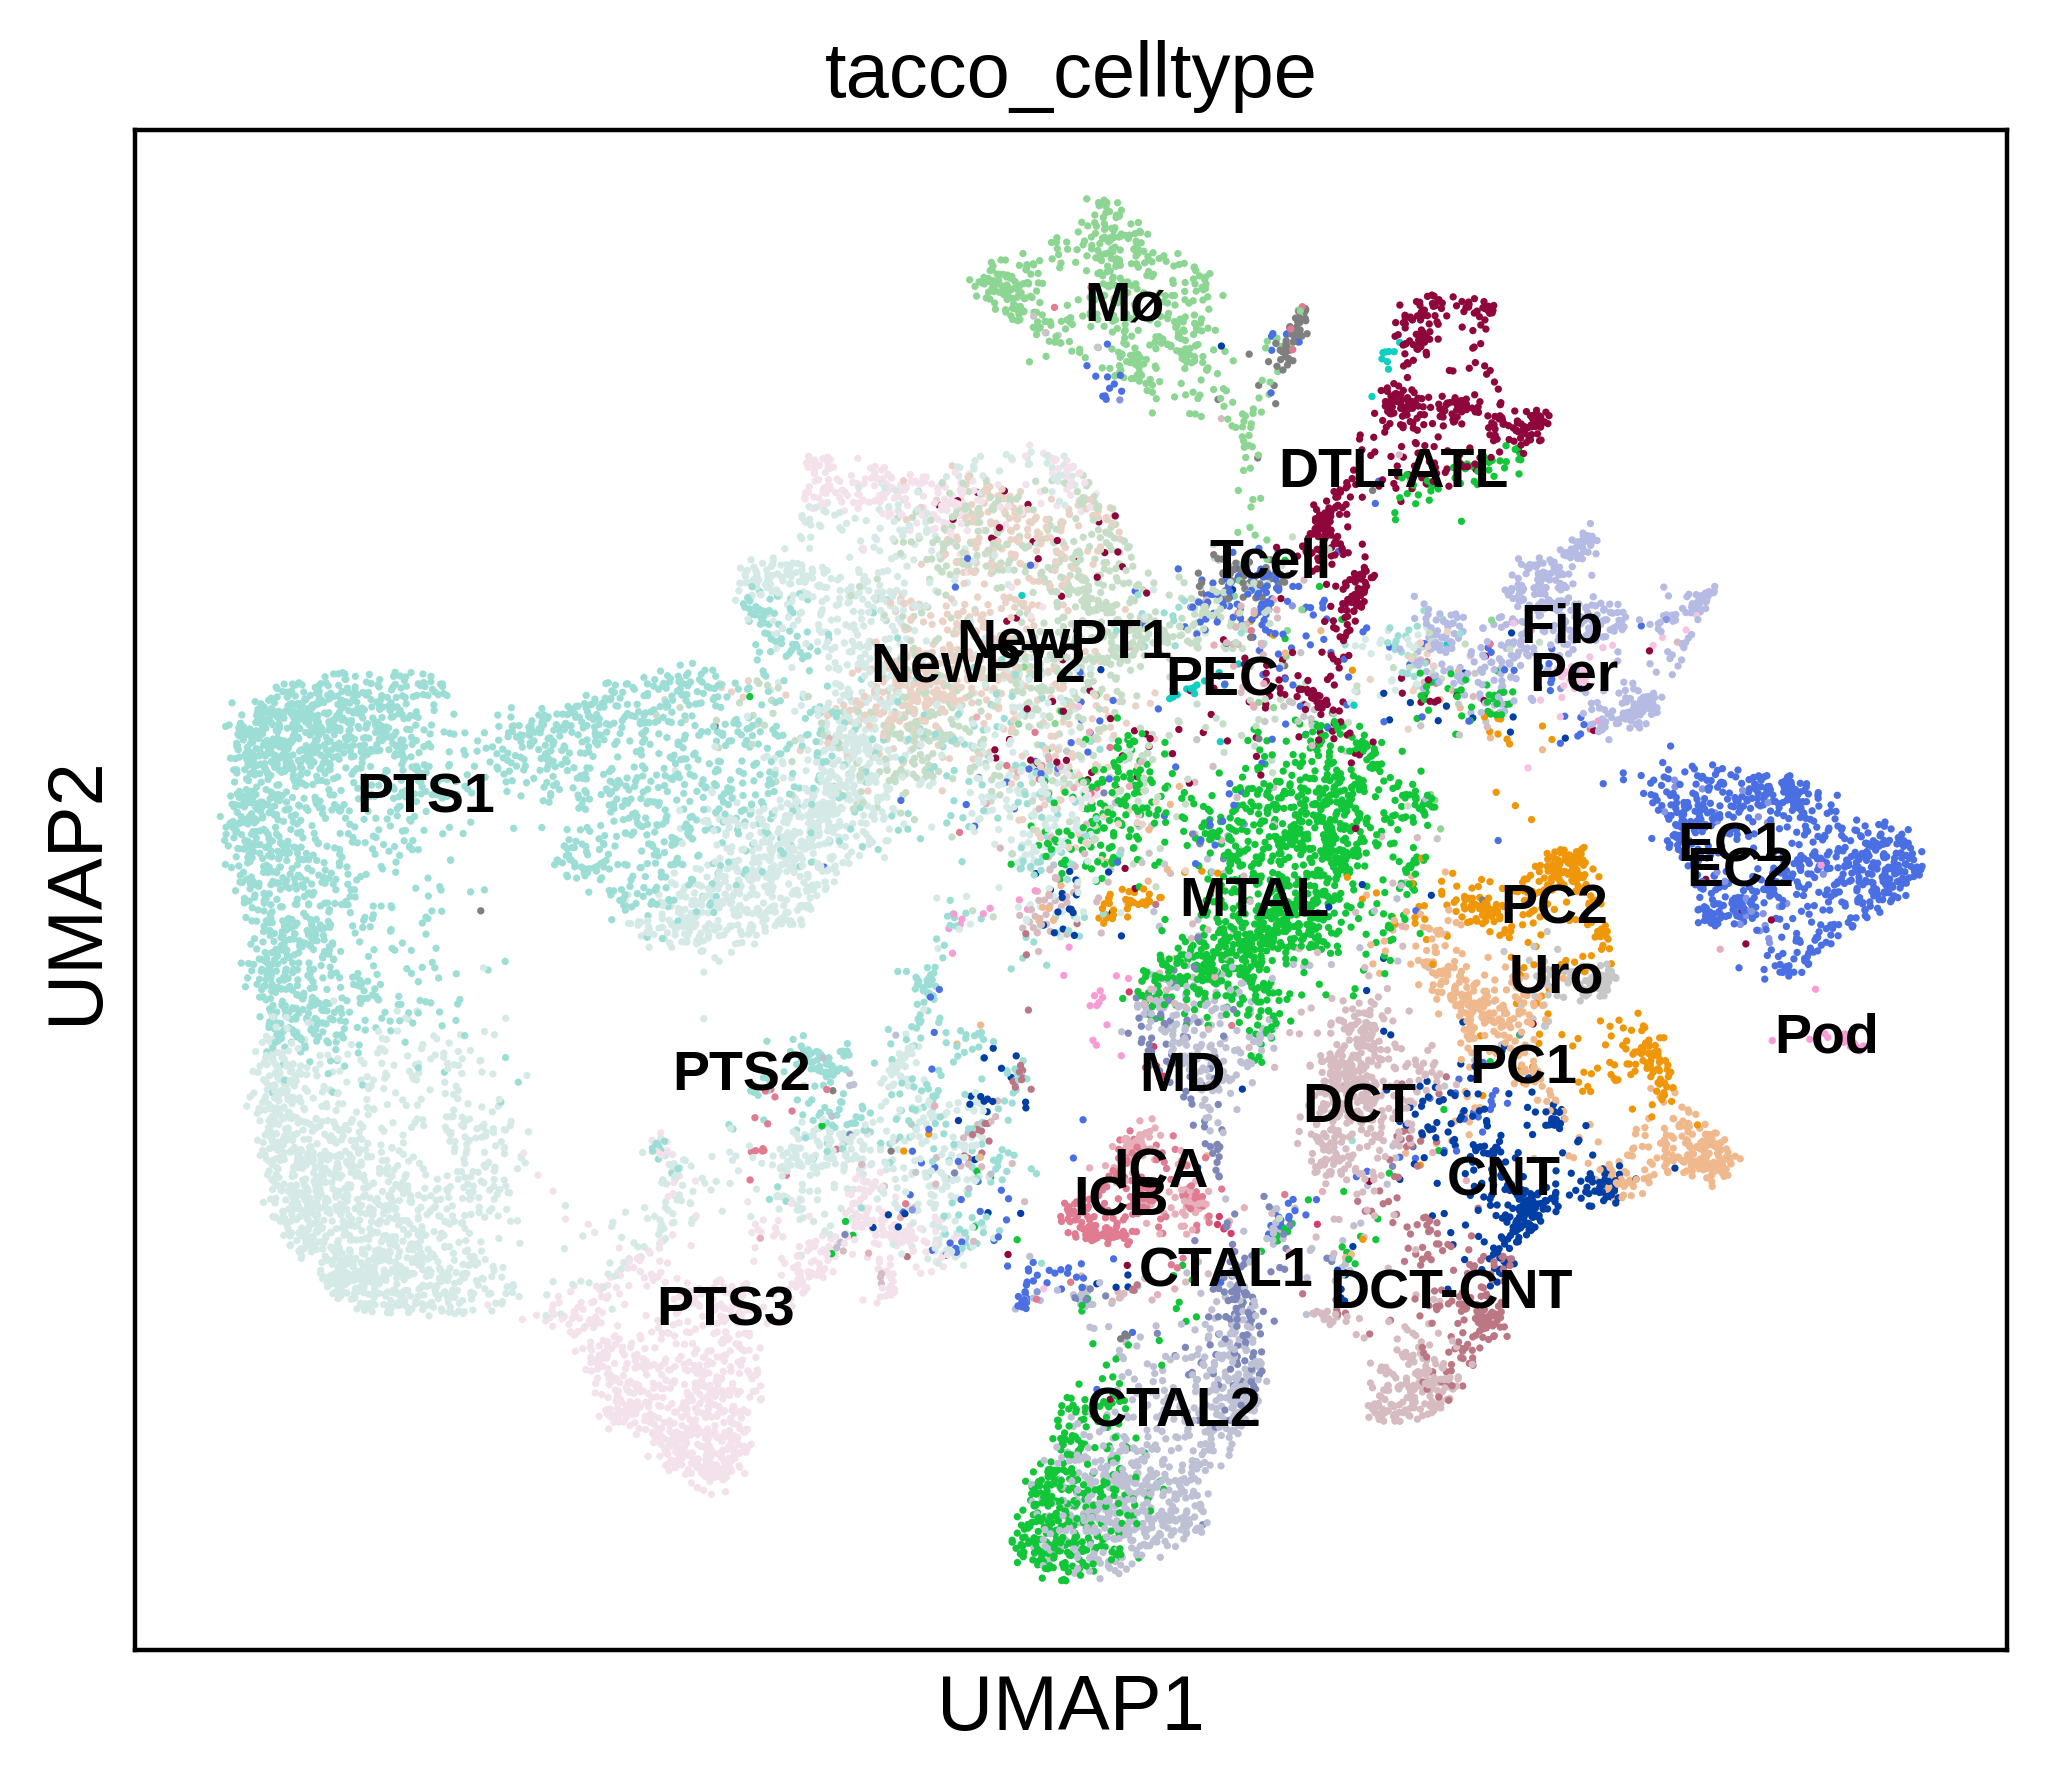

In [18]:
sc.pl.umap(adata, color=['tacco_celltype'], legend_loc='on data', legend_fontsize=10)